In [51]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from config import Config
from datetime import datetime
from img_embedding import ImageEmbedding
from img_transformer import ImgTransformer
from img_util import show_img_tensor_CHW
from fliker_comment_tokenizer import FlikerCommentTokenizer
from fliker_img_comment_dataset import ImgCommentDataset
from model_util import count_parameters
from pathlib import Path
from text_token_embedding import TextTokenEmbedding
from text_casual_mask_transformer import TextMaskedTransformer
from torch.utils.tensorboard import SummaryWriter


import torch
import torch.nn as nn
from torch.profiler import profile, record_function, ProfilerActivity
from torch.utils.data import DataLoader
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
config = Config()

train_dataset = ImgCommentDataset(config, split="train")
eval_dataset = ImgCommentDataset(config, split="eval")
test_dataset= ImgCommentDataset(config, split="test")
print(f"train_dataset:  {len(train_dataset)}")
print(f"eval_dataset:  {len(eval_dataset)}")
print(f"test_dataset:  {len(test_dataset)}")


# Data Loader
BATCH_SIZE = 20
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"train_dataloader:  {len(train_dataloader)}")
print(f"eval_data_loader:  {len(eval_dataloader)}")
print(f"test_data_loader:  {len(test_dataloader)}")


Enriched img id: /tmp/enriched_results.csv
tokens: 128000
tokenizer.is_fast: True
Enriched img id: /tmp/enriched_results.csv
tokens: 128000
tokenizer.is_fast: True
Enriched img id: /tmp/enriched_results.csv
tokens: 128000
tokenizer.is_fast: True
train_dataset:  114418
eval_dataset:  28605
test_dataset:  15892
train_dataloader:  5721
eval_data_loader:  1431
test_data_loader:  795


In [27]:
class ImgLanguageModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.config = config

        self.img_embedding = ImageEmbedding(config=config)
        self.img_transfomer = ImgTransformer(config=config)
        self.img_flatten = nn.Flatten(start_dim=1)
        self.img_proj = nn.Linear(in_features=config.img_patches* config.img_patch_embedding, out_features=config.img_text_proj_features)
        self.img_softmax = nn.LogSoftmax(dim=-1)

        # self.text_embedding = TextTokenEmbedding(config=config)
        self.text_transformer = TextMaskedTransformer(config=config)
        self.text_flatten = nn.Flatten(start_dim=1)
        self.text_proj = nn.Linear(in_features=config.max_text_len* config.text_token_embedding, out_features=config.img_text_proj_features)
        self.text_softmax = nn.LogSoftmax(dim=-1)
        
        self.diag_mask = torch.diag(torch.ones(config.img_text_proj_features))
        self.loss_fn = nn.NLLLoss()

    def forward(self, batch_img_tensor: torch.tensor, batch_text_tensor: torch.tensor, batch_img_id_tensor: torch.tensor=None):
        """
        batch_img_tensor: B x IMG_PATCHES x IMG_EMB
        batch_text_tensor: B x TEXT_TOKEN
        """
        img_embedding = self.img_embedding(batch_img_tensor) # B x IMG_PATCHES x IMG_EMB
        # print(f"img_encoding: {img_embedding.size()}")

        img_feature = self.img_transfomer(img_embedding) # B x IMG_PATCHES x IMG_EMB
        # print(f"img_feature: {img_feature.size()}")

        img_feature = self.img_flatten(img_feature)
        # print(f"img_feature: {img_feature.size()}")

        img_feature_proj = self.img_proj(img_feature)
        # print(f"img_feature: {img_feature.size()}")  # B x img_text_proj_features

        # text_embedding = self.text_embedding(batch_text_tensor)
        # print(f"text_embedding: {text_embedding.size()}")

        text_feature = self.text_transformer(batch_text_tensor)
        # print(f"text_feature: {text_feature.size()}")

        text_feature = self.text_flatten(text_feature)
        # print(f"text_feature: {text_feature.size()}")

        text_feature_proj = self.text_proj(text_feature)
        # print(f"text_feature: {text_feature.size()}")  # B x img_text_proj_features

        # Contrastive learning
        contrastive_scores = img_feature_proj @ text_feature_proj.T
        # print(f"contractive_scores: {contrastive_scores}")  # B x img_text_proj_features

        img_contrastive_prob = self.img_softmax(contrastive_scores)
        # print(f"img_contrastive_prob: {img_contrastive_prob}")  # B x img_text_proj_features
        
        target = torch.arange(img_contrastive_prob.size()[0], device=img_contrastive_prob.device)
        img_loss = self.loss_fn(img_contrastive_prob, target) / img_contrastive_prob.size()[0]
        # img_loss = self.loss_fn(img_contrastive_prob, self.target.expand(img_contrastive_prob.size()[0], -1))
        # print(f"img_loss: {img_loss}")

        text_contrastive_prob = self.text_softmax(contrastive_scores.T)
        # print(f"text_contrastive_prob: {text_contrastive_prob}")  # B x img_text_proj_features
        text_loss = self.loss_fn(text_contrastive_prob, target)  / text_contrastive_prob.size()[0]
        # print(f"text_loss: {text_loss}")
        
        return img_loss, text_loss, img_contrastive_prob, text_contrastive_prob

In [4]:
# train_dataset = ImgCommentDataset(config, split="train")

# BATCH_SIZE = 10
# train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

batch_img_tensor, batch_img_id_tensor, batch_comment_encoding = next(iter(train_dataloader))
print(f"batch_img_tensor: {batch_img_tensor.size()}")
print(f"batch_img_id_tensor: {batch_img_id_tensor.size()}")
print(f"batch_comment_encoding: {batch_comment_encoding.size()}")

batch_img_tensor: torch.Size([20, 3, 224, 224])
batch_img_id_tensor: torch.Size([20])
batch_comment_encoding: torch.Size([20, 50])


In [5]:
model = ImgLanguageModel(config=config)
img_loss, text_loss, img_contrastive_prob, text_contrastive_prob = model(batch_img_tensor=batch_img_tensor, batch_text_tensor=batch_comment_encoding, batch_img_id_tensor=batch_img_id_tensor)

pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"pytorch_total_params: {pytorch_total_params/10**6} m")
print(f"pytorch_total_trainable_params: {pytorch_total_trainable_params/10**6} m")
count_parameters(model)

tokens: 128000
tokenizer.is_fast: True
pytorch_total_params: 347.3374 m
pytorch_total_trainable_params: 347.3374 m
+-----------------------------------------------------------+------------+
|                          Modules                          | Parameters |
+-----------------------------------------------------------+------------+
|                 img_embedding.conv.weight                 |   559104   |
|                  img_embedding.conv.bias                  |    728     |
|             img_embedding.pos_embedding.weight            |   142688   |
|   img_transfomer.blocks.0.multihead_attention.wq.weight   |   529984   |
|    img_transfomer.blocks.0.multihead_attention.wq.bias    |    728     |
|   img_transfomer.blocks.0.multihead_attention.wk.weight   |   529984   |
|    img_transfomer.blocks.0.multihead_attention.wk.bias    |    728     |
|   img_transfomer.blocks.0.multihead_attention.wv.weight   |   529984   |
|    img_transfomer.blocks.0.multihead_attention.wv.bias    

347337400

In [6]:
EPOCHES = 1
EVAL_INTERVAL = 100
EVAL_STEPS = 10
lr = 0.001

device = torch.device("mps")

model = model.to(device)
optimizer =  torch.optim.AdamW(params=model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=EPOCHES)

def eval(model: ImgLanguageModel, global_step : int, writer: SummaryWriter):
    model.eval()

    avg_eval_loss = None
    eval_loss_std = None
    with torch.no_grad():
        eval_losses = []
        for i, data in enumerate(eval_dataloader):
            if i > EVAL_STEPS:
                # It takes significant time to do one full eval.
                break

            batch_img_tensor, batch_img_id_tensor, batch_target_tensor = data
            batch_img_tensor = batch_img_tensor.to(device)
            batch_target_tensor = batch_target_tensor.to(device)
            img_loss, text_loss, img_contrastive_prob, text_contrastive_prob = model(batch_img_tensor, batch_target_tensor)
            writer.add_scalar("eval/Img Loss", img_loss, global_step)
            writer.add_scalar("eval/Text Loss", text_loss, global_step)
            eval_losses.append(img_loss + text_loss)
        eval_losses = torch.tensor(eval_losses)
        avg_eval_loss = eval_losses.mean()
        eval_loss_std = eval_losses.std()
        writer.add_scalar("eval/Loss", avg_eval_loss, global_step)
        writer.add_scalar("Loss/eval-std", eval_loss_std, global_step)
    model.train()
    writer.flush()
    return avg_eval_loss, eval_loss_std
    


def train(model: ImgLanguageModel, writer: SummaryWriter):
    best_vloss = torch.tensor(1_000_000)
    with torch.profiler.profile(
            schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
            on_trace_ready=torch.profiler.tensorboard_trace_handler('./runs'),
            activities=[torch.profiler.ProfilerActivity.CPU], 
            record_shapes=True,
            profile_memory=True,
            with_stack=True
    ) as prof:
    # with torch.mps.profiler.profile(mode="interval", wait_until_completed=False):
        for epoch in range(EPOCHES): 
            for train_step, data in enumerate(train_dataloader):
                global_step = epoch * len(train_dataloader) + train_step

                # Profile
                if global_step < 1 + 1 + 3:
                    prof.step()

                batch_img_tensor, batch_img_id_tensor, batch_target_tensor = data
                batch_img_tensor = batch_img_tensor.to(device)
                batch_target_tensor = batch_target_tensor.to(device)

                # Viz Model
                if global_step == 0:
                    writer.add_graph(model, (batch_img_tensor, batch_target_tensor))

                optimizer.zero_grad()
                img_loss, text_loss, img_contrastive_prob, text_contrastive_prob = model(batch_img_tensor, batch_target_tensor)
                writer.add_scalar("train/Img Loss", img_loss, global_step)
                writer.add_scalar("train/Text Loss", text_loss, global_step)
                writer.add_scalar("train/Loss", img_loss+text_loss, global_step)
                writer.add_scalar("Learning Rate", scheduler.get_last_lr()[-1], global_step)
                loss = img_loss + text_loss
                loss.backward()
                optimizer.step()
                scheduler.step()

                if train_step > 0 and train_step % EVAL_INTERVAL == 0:
                    avg_vloss, _ = eval(model=model, global_step=global_step, writer=writer)
                
                    if avg_vloss is not None and avg_vloss < best_vloss:
                        best_vloss = avg_vloss
                        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                        model_path = f"vlm_contrastive_model_{epoch}_{timestamp}"
                        torch.save(model.state_dict(), model_path)

with SummaryWriter(flush_secs=1) as writer:
    train(model=model, writer=writer)

STAGE:2024-08-29 14:39:41 56286:6335949 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
[W CPUAllocator.cpp:235] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event
STAGE:2024-08-29 14:39:43 56286:6335949 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-08-29 14:39:43 56286:6335949 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [9]:
epoch = 1
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = f"vlm_contrastive_model_{epoch}_{timestamp}"
torch.save(model.state_dict(), model_path)

In [31]:
model_trained = ImgLanguageModel(config=config)
model_trained.load_state_dict(torch.load(model_path))
model_trained = model_trained.to(device)
model_trained.eval()


tokens: 128000
tokenizer.is_fast: True


ImgLanguageModel(
  (img_embedding): ImageEmbedding(
    (conv): Conv2d(3, 728, kernel_size=(16, 16), stride=(16, 16), padding=valid)
    (pos_embedding): Embedding(196, 728)
  )
  (img_transfomer): ImgTransformer(
    (blocks): Sequential(
      (0): ImgTransformerBlock(
        (multihead_attention): ImgMultiheadSelfAttention(
          (wq): Linear(in_features=728, out_features=728, bias=True)
          (wk): Linear(in_features=728, out_features=728, bias=True)
          (wv): Linear(in_features=728, out_features=728, bias=True)
          (norm): LayerNorm((728,), eps=1e-05, elementwise_affine=True)
          (softmax): Softmax(dim=-1)
        )
        (norm): LayerNorm((728,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=728, out_features=2912, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2912, out_features=728, bias=True)
          (3): Dropout(p=0.0, inplace=False)
        )
      )
     

In [32]:
batch_img_tensor, batch_img_id_tensor, batch_target_tensor = next(iter(train_dataloader))
batch_img_tensor = batch_img_tensor.to(device)
batch_target_tensor = batch_target_tensor.to(device)
img_loss, text_loss, img_contrastive_prob, text_contrastive_prob = model_trained(batch_img_tensor, batch_target_tensor)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


torch.Size([])


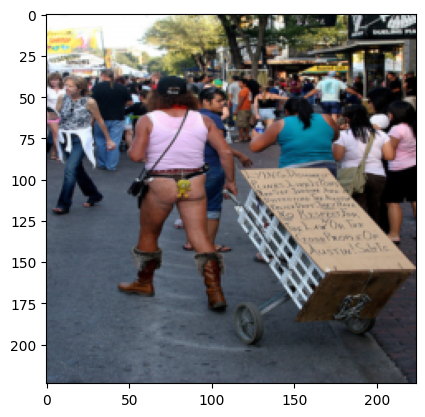

In [44]:
print(img_loss.size())
show_img_tensor_CHW(batch_img_tensor[19].cpu())

In [37]:
torch.argmax(img_contrastive_prob, dim=0)

tensor([ 0, 10, 13, 11,  8,  6, 10, 18,  5, 12,  3, 12,  4,  2, 15,  8, 18,  7,
        13, 19], device='mps:0')

In [45]:
model_trained.text_transformer.text_token_embedding.text_encoder.decode(batch_target_tensor[19])

'<bos>A man wearing a thong and furry boots walks down a crowded street towing a political agenda sign on wheels .<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [84]:
def show(imgs, comments, labels):
    if not isinstance(imgs, list):
        imgs = [imgs]
    imgs_per_row = 1
    fix, axs = plt.subplots(nrows=(len(imgs)+imgs_per_row-1)//imgs_per_row, ncols=imgs_per_row, squeeze=False, figsize=(16,60))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        row = i // imgs_per_row
        col = i % imgs_per_row
        axs[row, col].imshow(np.asarray(img))
        axs[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        title = f'pred: {comments[i].replace("<pad>", "").replace("<bos>", "")}\nlabel: {labels[i].replace("<pad>", "").replace("<bos>", "")}'
        axs[row, col].set_title(title)
        

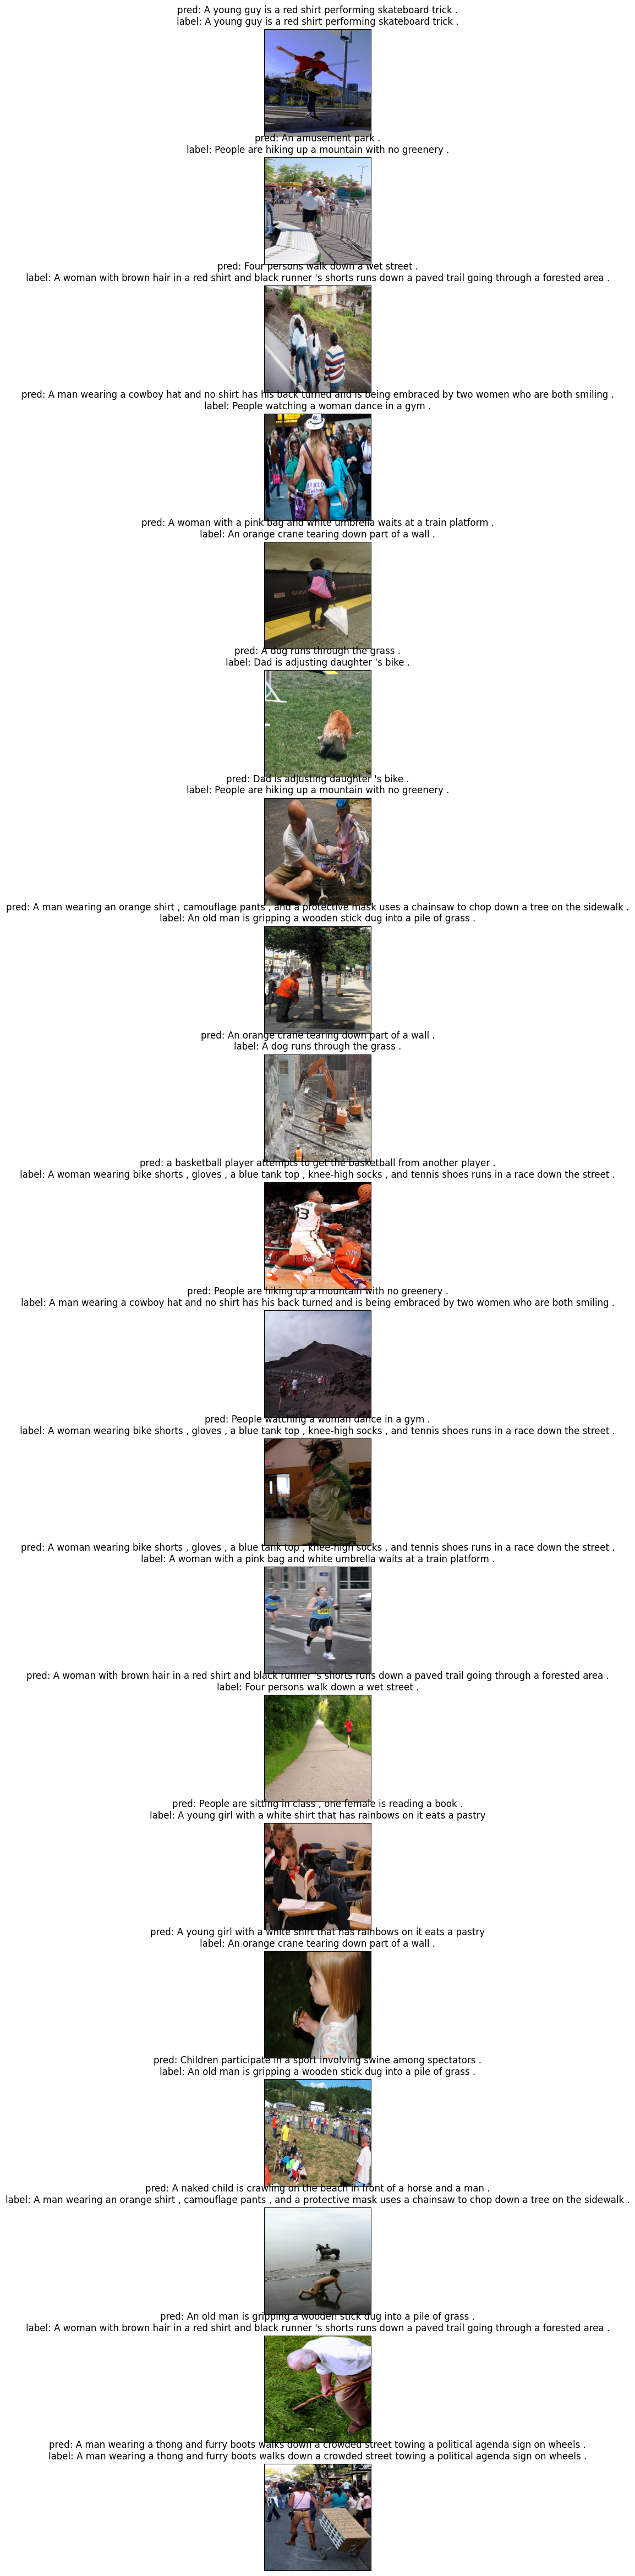

In [85]:
img_predicted_commments_index = torch.argmax(img_contrastive_prob, dim=0)

show(imgs = [img for img in batch_img_tensor.cpu()], 
     labels = [model_trained.text_transformer.text_token_embedding.text_encoder.decode(target_tensor) for target_tensor in batch_target_tensor],
     comments = [model_trained.text_transformer.text_token_embedding.text_encoder.decode(batch_target_tensor[predicted_comment_index]) for predicted_comment_index in img_predicted_commments_index],
     )
